In [ ]:
# DICE SM - Exploration & Global Sensitivity Analysis
# Shridhar
#  saved 140720 18:31

  ## Setup & Initialisation of levers and uncertainties

In [3]:
import time

import matplotlib.pyplot as plt
from ema_workbench import (Model, RealParameter, IntegerParameter, ArrayOutcome, TimeSeriesOutcome,
                           ema_logging, SequentialEvaluator,
                           MultiprocessingEvaluator)
from ema_workbench import save_results, load_results
from ema_workbench.analysis import prim
from ema_workbench.analysis import scenario_discovery_util as sdutil
from sklearn import preprocessing 
import numpy as np
ema_logging.log_to_stderr(ema_logging.INFO)
from ema_workbench.analysis import pairs_plotting
from dicemodel.noDICE_v3 import PyDICE


C:\Users\shrid\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [4]:

if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)
    

    model = PyDICE()
    dice_sm = Model('dicesmEMA', function=model)
    
    dice_sm.uncertainties = [IntegerParameter('t2xco2_index', 0, 999),
                            #  IntegerParameter('t2xco2_dist',0,2),
                             IntegerParameter('fdamage', 0, 2),
                             RealParameter('tfp_gr',  0.07, 0.09),
                             RealParameter('sigma_gr', -0.012, -0.008),
                             RealParameter('pop_gr', 0.1, 0.15),
                             RealParameter('fosslim',  4000.0, 13649),
                             IntegerParameter('cback', 100, 600)]
    
    dice_sm.levers = [RealParameter('sr', 0.1, 0.5),
                      RealParameter('prtp_con',  0.001, 0.015),
                      RealParameter('prtp_dam',  0.001, 0.015),
                      RealParameter('emuc',  0.1, 2.00),
                      RealParameter('emdd',  0.1, 2.00),
                      IntegerParameter('periodfullpart', 10, 58),
                      IntegerParameter('miu_period', 10, 58)]
    
    dice_sm.outcomes = [TimeSeriesOutcome('Atmospheric Temperature'),
                        TimeSeriesOutcome('Total Output'),
                        TimeSeriesOutcome('Population'),
                        TimeSeriesOutcome('Per Capita Consumption'),
                        TimeSeriesOutcome('Consumption Growth'),
                        TimeSeriesOutcome('Utility of Consumption'),
                        TimeSeriesOutcome('Per Capita Damage'),
                        TimeSeriesOutcome('Damage Growth'),
                        TimeSeriesOutcome('Disutility of Damage'),
                        TimeSeriesOutcome('Welfare'),
                        TimeSeriesOutcome('Consumption SDR'),
                        TimeSeriesOutcome('Damage SDR')

                        ]


In [11]:
n_scenarios = 100
n_policies = 50

In [14]:
n_scenarios = 100
n_policies = 50
start = time.time()
with MultiprocessingEvaluator(dice_sm, n_processes=8) as evaluator:
    results = evaluator.perform_experiments(scenarios=n_scenarios, policies=n_policies)
end = time.time()

print('Experiment time is ' + str(round((end - start)/60)) + ' mintues')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 100 scenarios * 50 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
Experiment time is 0 mintues


In [16]:
save_results(results, '1a_OE_100p_50s_v3.3.tar.gz')

[MainProcess/INFO] results saved successfully to e:\Year_2_Quarter_4\Thesis\06_Code\noDICE\1a_OE_100p_50s_v3.3.tar.gz


In [8]:
results = load_results('1a_OE_100p_50s_v3.3.tar.gz')
experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from e:\Year_2_Quarter_4\Thesis\06_Code\noDICE\1a_OE_100p_50s_v3.3.tar.gz


In [ ]:
import seaborn as sns
from ema_workbench.analysis import plotting, plotting_util
sns.set_style("whitegrid")

for outcome in outcomes.keys():
    fig,axes=plotting.lines(experiments, outcomes, outcomes_to_show=outcome, density=plotting.Density.BOXENPLOT)
    fig.set_size_inches(12, 5)
    fig.savefig('1a_TimeSeries_v3.3' + str(n_scenarios) +'s' + str(n_policies) + 'p' + '.png')
plt.show()


In [ ]:
## PRIM
# set x, y args + clean experiments + perform prim for diff outcomes + analyze (ref ...uncertaintystuff.ipynb)

In [13]:
# EMA I: Find a meaningful range for unknown EMDD variable 
# Method - UA: regions in EMDD space that has an impact with system behaviour
# I a. PRIM

In [18]:
# for x: Clean experiments
cleaned_experiments = experiments.drop(labels=[l.name for l in dice_sm.uncertainties], axis=1)
cleaned_experiments = experiments.drop(labels= ['policy', 'scenario', 'model'] , axis=1)
# type(cleaned_experiments)
cleaned_experiments

,cback,fdamage,fosslim,pop_gr,sigma_gr,t2xco2_index,tfp_gr,emdd,emuc,miu_period,periodfullpart,prtp_con,prtp_dam,sr
0,159.0,0.0,7820.928078,0.116270,-0.008595,531.0,0.083939,1.366865,0.882569,34.0,32.0,0.011595,0.012583,0.279459
1,455.0,0.0,9937.020574,0.149005,-0.011626,642.0,0.082917,1.366865,0.882569,34.0,32.0,0.011595,0.012583,0.279459
2,152.0,2.0,11606.690984,0.105389,-0.011121,55.0,0.079430,1.366865,0.882569,34.0,32.0,0.011595,0.012583,0.279459
3,176.0,1.0,11821.761832,0.137295,-0.010284,800.0,0.082747,1.366865,0.882569,34.0,32.0,0.011595,0.012583,0.279459
4,173.0,1.0,9293.269721,0.117383,-0.008011,125.0,0.083532,1.366865,0.882569,34.0,32.0,0.011595,0.012583,0.279459
5,231.0,0.0,13028.598478,0.103922,-0.010833,501.0,0.085657,1.366865,0.882569,34.0,32.0,0.011595,0.012583,0.279459
6,246.0,1.0,9767.991684,0.121638,-0.009483,69.0,0.086704,1.366865,0.882569,34.0,32.0,0.011595,0.012583,0.279459
7,384.0,2.0,12508.370735,0.139339,-0.010346,386.0,0.075227,1.366865,0.882569,34.0,32.0,0.011595,0.012583,0.279459
8,340.0,2.0,10817.988687,0.134771,-0.010986,434.0,0.078053,1.366865,0.882569,34.0,32.0,0.011595,0.012583,0.279459
9,502.0,0.0,6088.010723,0.145779,-0.011017,327.0,0.071634,1.366865,0.882569,34.0,32.0,0.011595,0.012583,0.279459


In [ ]:
# experiments_np = experiments.to_records()
# experiments_np

In [26]:
#  For y: outcomes is nd-array, PRIM needs 1D
y = outcomes
## verify

data_con_g = np.amax(y['Consumption Growth'], axis =1) 
data_con_g = data_con_g < 0
data_con_g
y['Welfare']

array([[-3853.04096089, -3851.08752734, -3849.15886697, ...,
        -3795.20446513, -3795.12709357, -3795.05445957],
       [-3853.04096309, -3851.03932201, -3849.03361917, ...,
        -3844.64853349, -3844.83605013, -3845.01030319],
       [-3853.03976778, -3851.1013125 , -3849.19767861, ...,
        -3814.59228385, -3811.7666787 , -3811.69319932],
       ...,
       [-3853.92756933, -3852.79241205, -3851.6303963 , ...,
        -3945.64894776, -3949.56077469, -3953.16388165],
       [-3853.9274844 , -3852.79270587, -3851.63131368, ...,
        -3939.31066237, -3941.75960599, -3944.01300412],
       [-3853.92756803, -3852.78277005, -3851.60486995, ...,
        -3834.2449817 , -3833.27339085, -3832.25428575]])

In [22]:
## reduce by Binary classification of results
# what range of outcome vars represents bad outcome - we want to find the contributing factors
# dice_sm.outcomes = [TimeSeriesOutcome('Atmospheric Temperature'),
#                         TimeSeriesOutcome('Total Output'),
#                         TimeSeriesOutcome('Population'),
#                         TimeSeriesOutcome('Per Capita Consumption'),
#                         TimeSeriesOutcome('Consumption Growth'),
#                         TimeSeriesOutcome('Utility of Consumption'),
#                         TimeSeriesOutcome('Per Capita Damage'),
#                         TimeSeriesOutcome('Damage Growth'),
#                         TimeSeriesOutcome('Disutility of Damage'),
#                         TimeSeriesOutcome('Welfare'),
#                         TimeSeriesOutcome('Consumption SDR'),
#                         TimeSeriesOutcome('Damage SDR')


# by value
data_temp = np.amax(y['Atmospheric Temperature'], axis =1) 
# np.max
y_temp = data_temp > 4.0

data_welfare = np.amax(y['Welfare'], axis =1)
# data_welfare = np.nan_to_num(data_welfare)
# np.any(np.isnan(data_welfare))
y_welfare = data_welfare < np.percentile(data_welfare, 20)


# by percentile
data_dpc = np.amax(y['Per Capita Damage'], axis =1)
y_dpc = data_dpc > np.percentile(data_dpc, 80)

data_cpc = np.amax(y['Per Capita Consumption'], axis =1)
y_cpc = data_cpc < np.percentile(data_cpc, 20) #what causes the least cpc outcomes

data_con_g = np.amax(y['Consumption Growth'], axis =1)
y_ = data_con_g > np.percentile(data_con_g, 80) # what causes the least growth outcomes


data_utility_con = np.amax(y['Utility of Consumption'], axis =1)
y_utility_con = data_utility_con < np.percentile(data_utility_con, 20)

data_disutil_dam = np.amax(y['Disutility of Damage'], axis =1)
y_disutil_dam = data_disutil_dam < np.percentile(data_disutil_dam, 20)


data_output = np.amax(y['Total Output'], axis = 1)
y_output = data_output < np.percentile(data_output, 20)

## verify
# y_damage.shape 
# y_temp
# y_temp.shape
# y['Welfare'].shape
# np.percentile(data_welfare, 20)
# plt.boxplot(data_welfare)
# data_welfare
np.any(np.isnan(data_welfare)) # there's a NaN = division by zero somewhere
# np.where(np.isnan(data_welfare))


False

In [ ]:
# data_welfare = data_welfare[~np.isnan(data_welfare)]


In [ ]:

# locating experiment
# experiments.ix[819].to_dict()



In [27]:
# change the y_... name to the name that will give you the outcome you want to analyse as defined above

# the meaning of peel_alpha is the percentile of the data that is to be removed
# The peeling alpha determines how much data is peeled off in each iteration of the algorithm. The lower the value, the less data is removed in each iteration. Controls the leniency of the algorithm, the higher the less lenient.


prim_alg = prim.Prim(x= cleaned_experiments, y=y_utility_con, threshold=0.8, peel_alpha=0.1) #0.1 

[MainProcess/INFO] 5000 points remaining, containing 1000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.14, coverage: 0.7, density: 1.0 restricted_dimensions: 3


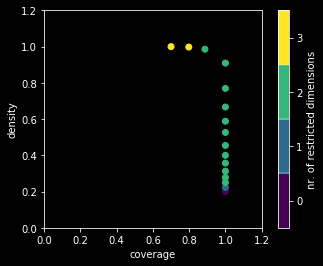

In [28]:
box1 = prim_alg.find_box()
# inspect_tradeoff()
box1.inspect_tradeoff()
box1.show_tradeoff()
plt.show()

In [ ]:
box1.inspect()
plt.show()


In [ ]:
box1.select(14)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
# PRIM for Welfare
prim_alg = prim.Prim(x= cleaned_experiments, y=y_welfare, threshold=0.8, peel_alpha=0.1) 

box1 = prim_alg.find_box()
box1.inspect_tradeoff()
plt.show()

# welfare only has false (no cases of interest)

In [ ]:
%debug


In [ ]:
box1.inspect()
plt.show()

In [ ]:
box1.select(13)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
# boxes = prim_alg.show_boxes()
prim.Prim.show_boxes(prim_alg)
# #visualize
# prim.show_boxes_individually(boxes, results)
# prim.show_boxes_together(boxes, results)
# plt.show()

In [ ]:
## put results in excel
import pandas as pd

outcomes_df = pd.DataFrame(max_outcomes, index = df_index)
experiments_df = pd.DataFrame(experiments)
df_results = pd.concat([outcomes_df, experiments_df], axis=1)
df_results.to_excel("r_100s_10p.xlsx")

In [ ]:
''' 
########################## adapted from EMA workbench Mexican Flu example #################################
Converting the outcome into a dictionary when PRIM returns a TypeError due to unhashable dictionary
prim.prim requires y to be a 1D array, so why are we doing this?

Is there some other way we can use the flu example for scenario discovery?
In the flu example, there is a zero policy already decided through vensim, but here we are trying to find 
the most vulnerable scenarios across a large ensemble of policies through PRIM.
i.e. we use PRIM to get uncertainty + policy subspace which gives undesirable outcomes 
'''
# transform the outcomes to the required format 

y_dict = {}


# get time and remove it from the dict
for key, value in outcomes.items():
    if key == 'Atmospheric Temperature':
        max_temp = np.max(value, axis=1)
        y_dict['max temp'] = max_temp
    else:
        y_dict[key] = value[:, -1]
y_dict



# commenting out because we don't have a time index
        # we want the time at which the maximum occurred
        # the code here is a bit obscure, I don't know why the transpose
        # of value is needed. This however does produce the appropriate results
#         logical = value.T == np.max(value, axis=1)
#         tr['time of max'] = time[logical.T]